## IF Approach

In [1]:
import findspark
import pandas as pd
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf

# for shared metastore (shared across all users)
spark = SparkSession.builder.appName("Seq").config("hive.metastore.uris", "thrift://amok:9083", conf=SparkConf()).getOrCreate() \

# for local metastore (your private, invidivual database) add the following config to spark session
spark.sql("USE 2023_11_02")

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/opt/hadoop-3.2.2/share/hadoop/common/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/opt/apache-hive-2.3.7-bin/lib/log4j-slf4j-impl-2.6.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
2024-01-21 23:52:32,501 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2024-01-21 23:52:33,671 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
2024-01-21 23:52:35,454 WARN spark.ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental f

DataFrame[]

In [2]:
#import pyspark.pandas as ps
from pyspark.sql.functions import lit,col
import pandas as pd
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
#from boruta import BorutaPy
#from fredapi import Fred
from sklearn.linear_model import Lasso
from sklearn.model_selection import TimeSeriesSplit
import csv
from pyspark.sql import functions as F
from functools import reduce
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from CreateDataset import get_full_seqs, get_seq_means

## Aggregating Time Series

In [17]:
df = pd.read_csv('imploded_stocks_price.csv', index_col=False)
df['Implosion_Start_Date'] = pd.to_datetime(df['Implosion_Start_Date'])
df['Implosion_End_Date'] = pd.to_datetime(df['Implosion_End_Date'])
df = get_seq_means(df)

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


In [18]:
df.show()

+--------+-------------------+--------------------+--------------------+-------------------+------------------+-------------------+----------+-------------------+--------------------+--------------------+--------------------------+--------------------+-------------------+-------------------+----------------------+------------------+------------------+--------------------+--------------------+----------------------+------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-----+
| fsym_id|       ff_assets_gr|  ff_net_inc_per_emp|  ff_debt_entrpr_val|         ff_fcf_yld|        ff_sga_oth|   ff_gross_cf_debt|ff_dil_adj|       ff_shs_float|             ff_xord|         ff_inc_sund|ff_net_inc_basic_beft_xord|     ff_non_oper_exp|        ff_cf_ps_gr|          ff_emp_gr|ff_net_inc_bef_xord_gr|      ff_com_eq_gr|     ff_mkt_val_gr|           ff_zscore|ff_dfd_tax_assets_lt|ff_ut_non_oper_inc_o

In [19]:
print(df.count())
print(df.filter(col('label') == 1).count())

10826


608


In [5]:
null_counts = df.select([F.sum(col(column).isNull().cast("int")).alias(column + "_null_count") for column in df.columns])
result_df = null_counts.toPandas()
result_df = result_df.transpose()
result_df.columns = ['Null Count']
print(result_df)

2024-01-21 23:54:38,210 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


                                       Null Count
fsym_id_null_count                              0
ff_assets_gr_null_count                       188
ff_net_inc_per_emp_null_count                1061
ff_debt_entrpr_val_null_count                 500
ff_fcf_yld_null_count                        1222
ff_sga_oth_null_count                        2085
ff_gross_cf_debt_null_count                   713
ff_dil_adj_null_count                          51
ff_shs_float_null_count                      1382
ff_xord_null_count                             27
ff_inc_sund_null_count                         24
ff_net_inc_basic_beft_xord_null_count          26
ff_non_oper_exp_null_count                    338
ff_cf_ps_gr_null_count                       1118
ff_emp_gr_null_count                         1616
ff_net_inc_bef_xord_gr_null_count             635
ff_com_eq_gr_null_count                       285
ff_mkt_val_gr_null_count                     1379
ff_zscore_null_count                         2645


In [20]:
df = df.drop('ff_zscore', 'ff_mkt_val_gr','ff_mkt_val_public', 'ff_emp_gr', 'ff_sales_fix_assets', 'ff_cf_ps_gr', 'ff_shs_float', 'ff_sga_oth', 'ff_fcf_yld', 'ff_net_inc_per_emp')

In [21]:
print(df.count())
print(df.dropna().count())
print(df.dropna().filter(col('label')==1).count())

10826


8793


589


In [22]:
df=df.dropna()
print(df.count())
print(df.filter(col('label')==1).count())

8793


589


### Helper Functions

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def t_t_split(df):
    train, test = df.randomSplit([0.8,0.2])
    return train, test


def confusion_matrix_pandas(df):
    df = df.toPandas()
    cm = confusion_matrix(df['label'], df['prediction'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    

In [14]:
from hyperopt import fmin, tpe, hp
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import csv
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from itertools import chain
    
def model_training(df, classifier):
    
    print("Number of records: ", df.count())
    
    features = df.columns[1:-1]
    
    train_df, test_df = t_t_split(df)
    
        
    def compute_weights(train_df):
        y_collect = train_df.select("label").groupBy("label").count().collect()
        unique_y = [x["label"] for x in y_collect]
        total_y = sum([x["count"] for x in y_collect])
        unique_y_count = len(y_collect)
        bin_count = [x["count"] for x in y_collect]

        class_weights_spark = {i: ii for i, ii in zip(unique_y, total_y / (unique_y_count * np.array(bin_count)))}
        print(class_weights_spark)
        mapping_expr = F.create_map([F.lit(x) for x in chain(*class_weights_spark.items())])
        train_df = train_df.withColumn("weight", mapping_expr.getItem(F.col("label")))
        return train_df
        
    train_df = compute_weights(train_df)
    
    vector_assembler = VectorAssembler(inputCols=features, outputCol="features_vector")
    train_df = vector_assembler.transform(train_df)
    test_df = vector_assembler.transform(test_df)

    if classifier == 'LogisticRegression':
        param_space = {
            'regParam': hp.uniform('regParam', 0.01, 1.0),
            'elasticNetParam': hp.uniform('elasticNetParam', 0.0, 1.0)
        }
        classifier_instance = LogisticRegression(featuresCol="features_vector", labelCol="label", weightCol='weight')
    elif classifier == 'RandomForest':
        param_space = {
            'maxBins': hp.quniform('maxBins', 16, 32, 1),
            'maxDepth': hp.quniform('maxDepth', 20, 30, 1)
        }
        classifier_instance = RandomForestClassifier(featuresCol='features_vector', labelCol='label', weightCol='weight')
    elif classifier == 'GBT':
        param_space = {
            'maxDepth' : hp.quniform("maxDepth", 3, 18, 1),
            'maxBins': hp.quniform('maxBins', 16, 32, 1)
        }
        classifier_instance = GBTClassifier(featuresCol='features_vector', labelCol='label')
    else:
        raise ValueError("Unsupported classifier")
    
    initial_model = classifier_instance
    initial_model = initial_model.fit(train_df)

    def cross_val_train(params):
        classifier_instance.setParams(**params)
        evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
        train, val = train_df.randomSplit([0.9,0.1])
        curr_model = classifier_instance.fit(train)
        predictions = curr_model.transform(val)
        val_metric = evaluator.evaluate(predictions)
        return curr_model, val_metric
#         crossval = CrossValidator(estimator=classifier_instance,
#                                   estimatorParamMaps=[params],
#                                   evaluator=evaluator,
#                                   numFolds=5, parallelism=12)
        
#         cv_model = crossval.fit(train_df)
#         predictions = cv_model.transform(train_df)
#         val_metric = evaluator.evaluate(predictions)
#         return cv_model, val_metric
    
    
    def objective(params):
        model, metric = cross_val_train(params)
        return -metric

    # Find the best hyperparameters
    best_params = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=3)
    print("Best hyperparameters: ", best_params)

    # Train the model with the best hyperparameters
    best_model, final_metric = cross_val_train(best_params)
            
    
    predictions = best_model.transform(test_df)
    true = predictions.select('label').toPandas()
    preds = predictions.select('prediction').toPandas()
    print(classification_report(true, preds))
    
    cm = confusion_matrix(true, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    return best_model, train_df, test_df
    
model, train_df, test_df = model_training(df, 'GBT')

Number of records:  8793


{1: 7.728070175438597, 0: 0.5345873786407767}


  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]

2024-01-22 00:39:44,910 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1011.3 KiB
2024-01-22 00:39:47,082 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1021.0 KiB
2024-01-22 00:39:49,199 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1029.9 KiB
2024-01-22 00:39:51,105 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1035.2 KiB
2024-01-22 00:39:53,028 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1000.3 KiB
2024-01-22 00:39:55,152 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1000.7 KiB
2024-01-22 00:39:56,863 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1001.5 KiB
2024-01-22 00:39:58,659 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1002.5 KiB
2024-01-22 00:40:00,468 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1004.8 KiB
2024-01-22 00:40:02,444 WARN scheduler.DAGScheduler: Br

  0%|          | 0/3 [08:08<?, ?trial/s, best loss=?]

2024-01-22 00:42:40,317 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1362.0 KiB


KeyboardInterrupt: 

check_additivity requires us to run predictions which is not supported with spark, ignoring. Set check_additivity=False to remove this warning


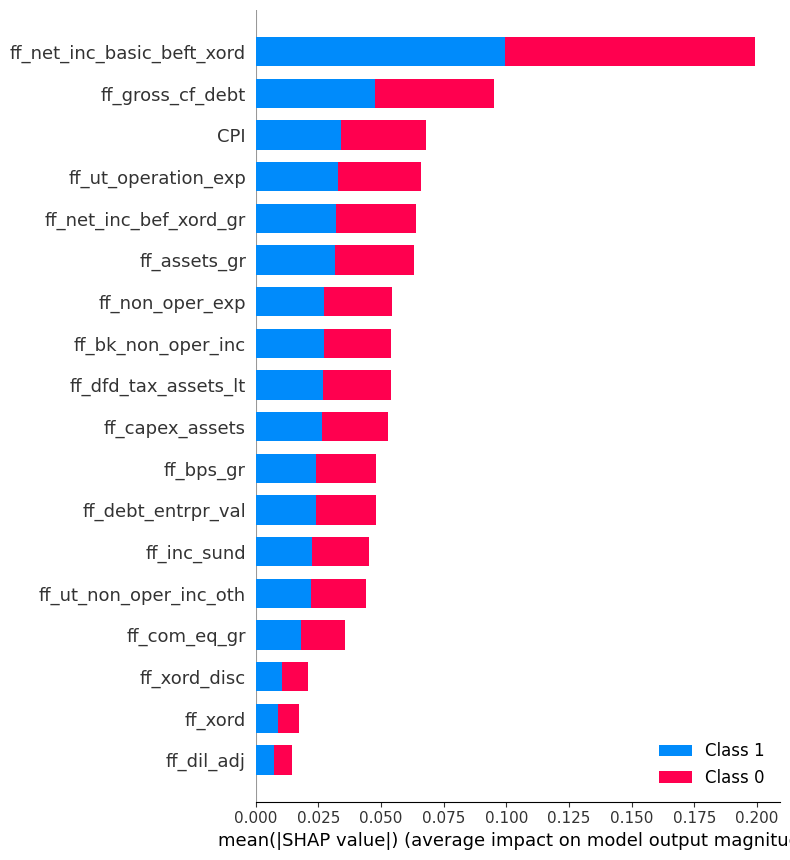

In [13]:
import shap

def feat_analysis(model):
    features = df.columns[1:-1]
    feature_importances = model.featureImportances
    feature_importances = feature_importances.toArray()
    sorted_idx = np.argsort(feature_importances)[::-1]
    sorted_features = [features[i] for i in sorted_idx]

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], align="center")
    plt.xticks(range(len(feature_importances)), sorted_features, rotation=45, ha="right")
    plt.xlabel("Feature")
    plt.ylabel("Feature Importance")
    plt.title("Feature Importances")
    plt.show()
    
    
def shapley(model, train, test):
    exclude_columns = ['fsym_id',  'label', 'features_vector']
    train = train.toPandas()
    test = test.toPandas()
    X_train = train.drop(exclude_columns, axis=1)
    X_test = test.drop(exclude_columns, axis=1)
    explainer = shap.Explainer(model)
    shap_values = explainer.shap_values(X_test)
    shap.initjs()
    # print(shap_values.shape)
    shap.summary_plot(shap_values, X_test)
    
    
# feat_analysis(model)
shapley(model, train_df, test_df)

Converted to Pandas
       fsym_id  ff_assets_gr  ff_debt_entrpr_val  ff_gross_cf_debt  \
0     BHZYXG-R     39.423005           -0.013811      -2334.600441   
1     BW85Z6-R    -13.024455            0.005156      -9219.653258   
2     BYNP13-R     24.465587            0.371030         27.709880   
3     DKMTLY-R   2955.132110            0.594343        -40.071781   
4     F1B8CH-R     16.333759            0.549298          9.117243   
...        ...           ...                 ...               ...   
7060  V4QFTG-R    279.321653            0.073986       -213.616775   
7061  VMKJZX-R     73.582908            0.757290        -72.810034   
7062  W2X8SW-R     26.795276           -5.439738       -103.685797   
7063  WV6YVV-R    400.884436            0.237671       -405.669803   
7064  XHBMVN-R     25.152466            0.013669       -151.342778   

      ff_dil_adj       ff_xord  ff_inc_sund  ff_net_inc_basic_beft_xord  \
0       0.000000 -1.762454e+00     1.711586                   -8

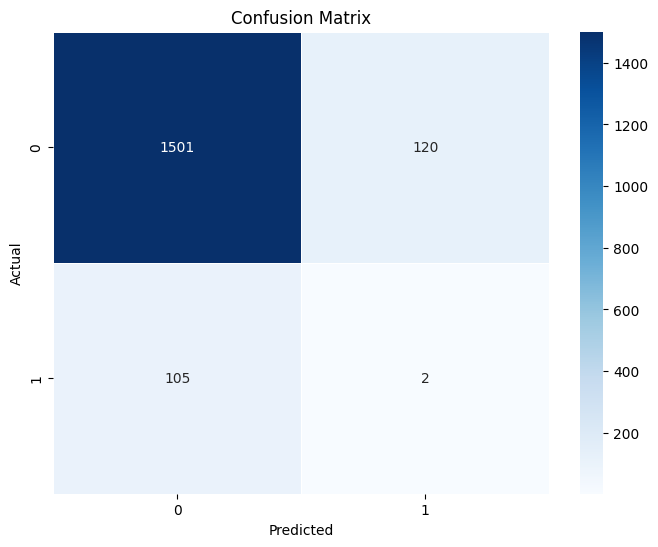

In [28]:
from sklearn.ensemble import IsolationForest

def anomaly_det(df):
    train_df, test_df = t_t_split(df)
    features = df.columns[1:-1]
    train_df = train_df.toPandas()
    test_df = test_df.toPandas()
    print("Converted to Pandas")
    
    num_pos = len(train_df[train_df['label']==1])
    isol_for = IsolationForest(contamination=num_pos/len(train_df), random_state=41)
    isol_for.fit(train_df[features])
    train_df['anomaly_scores'] = isol_for.decision_function(train_df[features])
    train_df['anomaly'] = isol_for.predict(train_df[features])
    train_df['preds'] = np.where(train_df['anomaly'] == 1, 0, 1)
    
    test_df['anomaly_scores'] = isol_for.decision_function(test_df[features])
    test_df['anomaly'] = isol_for.predict(test_df[features])
    test_df['preds'] = np.where(test_df['anomaly'] == 1, 0, 1)
    
    print(train_df)
    print(f"Classification Report: ")
    print(classification_report(test_df['label'], test_df['preds']))
    cm = confusion_matrix(test_df['label'], test_df['preds'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    
    
anomaly_det(df)

In [15]:
df = pd.read_csv('imploded_stocks_price.csv', index_col=False)
df['Implosion_Start_Date'] = pd.to_datetime(df['Implosion_Start_Date'])
df['Implosion_End_Date'] = pd.to_datetime(df['Implosion_End_Date'])
df = get_full_seqs(df)

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
2024-01-22 00:43:03,914 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1331.5 KiB
2024-01-22 00:43:08,025 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1335.9 KiB
2024-01-22 00:43:11,530 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1342.5 KiB
2024-01-22 00:43:15,251 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1352.0 KiB
iteritems is deprecated and will be removed in a future version. Use .items instead.
2024-01-22 00:43:19,064 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1363.9 KiB


In [4]:
df.show()

2024-01-20 20:53:18,456 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
2024-01-20 20:53:24,727 WARN scheduler.TaskSetManager: Stage 0 contains a task of very large size (2969 KiB). The maximum recommended task size is 1000 KiB.


+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------------+--------------------+--------------------+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
| fsym_id|        ff_assets_gr|  ff_net_inc_per_emp|  ff_debt_entrpr_val|          ff_fcf_yld|          ff_sga_oth|    ff_gross_cf_debt|          ff_dil_adj|        ff_shs_float|             ff_xord|         ff_inc_sund|ff_net_inc_basic_beft_xord|     ff_non_oper_exp|         ff_cf_ps_gr|           ff_emp_gr|ff_net_inc_bef_xord_gr|        ff_com_eq_gr|       ff_mkt_val_gr|          

2024-01-22 00:43:21.230792: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-22 00:43:21.230842: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-22 00:43:21.232807: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-22 00:43:21.242704: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-22 00:43:21,895 WARN scheduler.DAGScheduler: 

Number of records:  4483


2024-01-22 00:43:43,864 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1393.1 KiB
2024-01-22 00:43:49,178 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1394.2 KiB
2024-01-22 00:43:56,576 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1396.5 KiB
2024-01-22 00:44:04,917 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1400.9 KiB


Number of records:  4476
['ff_assets_gr', 'ff_net_inc_per_emp', 'ff_debt_entrpr_val', 'ff_fcf_yld', 'ff_sga_oth', 'ff_gross_cf_debt', 'ff_dil_adj', 'ff_shs_float', 'ff_xord', 'ff_inc_sund', 'ff_net_inc_basic_beft_xord', 'ff_non_oper_exp', 'ff_cf_ps_gr', 'ff_emp_gr', 'ff_net_inc_bef_xord_gr', 'ff_com_eq_gr', 'ff_mkt_val_gr', 'ff_zscore', 'ff_dfd_tax_assets_lt', 'ff_ut_non_oper_inc_oth', 'ff_mkt_val_public', 'ff_xord_disc', 'ff_bps_gr', 'ff_ut_operation_exp', 'ff_sales_fix_assets', 'CPI', 'ff_bk_non_oper_inc', 'ff_capex_assets']


2024-01-22 00:44:10,528 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1407.5 KiB
2024-01-22 00:44:13,620 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1416.9 KiB
2024-01-22 00:44:16,523 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1428.6 KiB
2024-01-22 00:44:19,541 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1442.5 KiB
2024-01-22 00:44:22,857 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1455.9 KiB
2024-01-22 00:44:25,985 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1468.3 KiB
2024-01-22 00:44:28,961 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1478.0 KiB
2024-01-22 00:44:31,581 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1486.6 KiB
2024-01-22 00:44:34,656 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1491.7 KiB
2024-01-22 00:44:37,972 WARN scheduler.DAGScheduler: Br

43
{0: 0.5273749630068068, 1: 9.632432432432433}
Epoch 1/50
101/101 [==============================] - 1s 5ms/step - loss: 1.2784 - accuracy: 0.4955 - val_loss: 0.6492 - val_accuracy: 0.4426
Epoch 2/50
101/101 [==============================] - 0s 3ms/step - loss: 1.1294 - accuracy: 0.5772 - val_loss: 0.6535 - val_accuracy: 0.5126
Epoch 3/50
101/101 [==============================] - 0s 3ms/step - loss: 0.6209 - accuracy: 0.7802 - val_loss: 0.5706 - val_accuracy: 0.8179
Epoch 4/50
101/101 [==============================] - 0s 3ms/step - loss: 0.5400 - accuracy: 0.8460 - val_loss: 0.4622 - val_accuracy: 0.9076
Epoch 5/50
101/101 [==============================] - 0s 2ms/step - loss: 0.5012 - accuracy: 0.8943 - val_loss: 0.4530 - val_accuracy: 0.8880
Epoch 6/50
101/101 [==============================] - 0s 2ms/step - loss: 0.4504 - accuracy: 0.9002 - val_loss: 0.4459 - val_accuracy: 0.8880
Epoch 7/50
101/101 [==============================] - 0s 3ms/step - loss: 0.5441 - accuracy: 0.9108

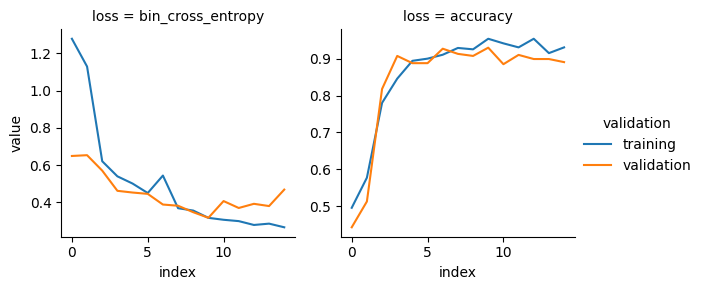

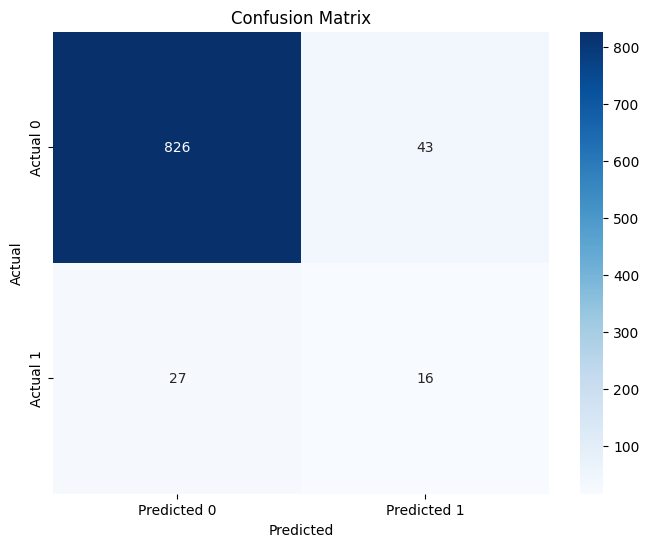

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report


def nn_prepare_seqs(df):
    # print(df.columns)
    print("Number of records: ", df.count())
    df = df.filter(reduce(lambda acc, column: acc & (F.size(col(column)) == 22), df.columns[1:-1], F.lit(True)))
    print("Number of records: ", df.count())
    features = df.columns[1:-1]
    print(features)
    label_col = 'label'

    def convert_to_np_array(row):
        seq_feats = row.seq_feats
        label = row.label
        feat_length = len(seq_feats[0])
        date_length = len(seq_feats[0][0])
        seq_array = np.zeros((feat_length, date_length))
        for i, sublist in enumerate(seq_feats[0]):
            seq_array[i, :] = np.array(sublist)
        seq_array = seq_array.T
        return (seq_array, label)
    
    # train_seqs_rdd = grouped_data.rdd.map(convert_to_np_array)
    train_df, test_df = t_t_split(df)
    
    # train_seqs = []
    # for stock_id, group in df.groupby('fsym_id'):
    #     seq_feats = group[features]
    #     label = group['label']
    #     feat_length = len(seq_feats.iloc[0])
    #     date_length = len(seq_feats.iloc[0,0])
    #     seq_array = np.zeros((feat_length, date_length))
    #     for i, sublist in enumerate(seq_feats.columns):
    #         seq_array[i, :] = np.array(seq_feats[sublist].iloc[0])
    #     seq_array = seq_array.T
    #     train_seqs.append((seq_array, label))
        
        
    # df= df.toPandas()
    # print(df.head())
    # features = df.columns[1:-1]
    # list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
    # df = df.toPandas()
    
    
    
    # for f in features:
    #     df = df.withColumn(f, list_to_vector_udf(f))
    # train_df, test_df = train_test_split(df)
    train_df = train_df.toPandas()
    test_df = test_df.toPandas()
    
    train_seqs = []
    for stock_id, group in train_df.groupby('fsym_id'):
        seq_feats = group[features]
        label = group['label']
        feat_length = len(seq_feats.iloc[0])
        date_length = len(seq_feats.iloc[0,0])
        seq_array = np.zeros((feat_length, date_length))
        for i, sublist in enumerate(seq_feats.columns):
            seq_array[i, :] = np.array(seq_feats[sublist].iloc[0])
        seq_array = seq_array.T
        train_seqs.append((seq_array, label))
        
    test_seqs = []
    for stock_id, group in test_df.groupby('fsym_id'):
        seq_feats = group[features]
        label = group['label']
        feat_length = len(seq_feats.iloc[0])
        date_length = len(seq_feats.iloc[0,0])
        seq_array = np.zeros((feat_length, date_length))
        for i, sublist in enumerate(seq_feats.columns):
            seq_array[i, :] = np.array(seq_feats[sublist].iloc[0])
        seq_array = seq_array.T
        test_seqs.append((seq_array, label))
    
    return train_seqs, test_seqs

def plot_model_performance(mdl, loss, metric):
    x = pd.DataFrame(mdl.history).reset_index()
    x = pd.melt(x, id_vars='index')
    x['validation'] = (x['variable'].str[:4] == 'val_').replace({True:'validation',False:'training'})
    x['loss'] = (x['variable'].str[-4:] == 'loss').replace({True:loss,False:metric})
    g = sns.FacetGrid(x, col='loss', hue='validation',sharey=False)
    g.map(sns.lineplot, 'index','value')
    g.add_legend()
    return g

def nn_training(train_seqs, test_seqs):
    train_X, train_y = zip(*train_seqs)
    test_X, test_y = zip(*test_seqs)

    # Convert lists to numpy arrays
    train_X = np.array(train_X)
    train_y = np.array(train_y)
    test_X = np.array(test_X)
    test_y = np.array(test_y)
    print(np.sum(test_y==1))
    
    class_labels = np.unique(train_y)
    class_weights = compute_class_weight('balanced', classes=class_labels, y=train_y.flatten())
    class_weight_dict = dict(zip(class_labels, class_weights))
    print(class_weight_dict)
    

    # Define the neural network model
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(train_X.shape[1], train_X.shape[2])),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),  # Additional Dense layer
        tf.keras.layers.Dropout(0.5),  # Dropout layer for regularization
        tf.keras.layers.Dense(16, activation='relu'),  # Another Dense layer
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    loss_fn = keras.losses.BinaryCrossentropy()
    optimizer = keras.optimizers.Adam(
        learning_rate=0.01
    )

    
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

    # Train the model
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    fit_model = model.fit(train_X, train_y, epochs=50, batch_size=32, validation_split=0.1, class_weight = class_weight_dict, callbacks=[early_stopping])
    plot_model_performance(fit_model, 'bin_cross_entropy','accuracy')

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(test_X, test_y)
    print(f'Test accuracy: {test_acc}')

    # Make predictions on new data
    predictions = model.predict(test_X)
    for i in range(len(predictions)):
        predictions[i] = 1 if predictions[i] >= 0.5 else 0
    print(classification_report(predictions, test_y.flatten()))
    
    # pred_df = pd.DataFrame()
    # pred_df['prediction'] = predictions
    # pred_df['label'] = test_y
    # confusion_matrix_pandas(pred_df)
    cm = confusion_matrix(test_y, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    

train_seqs, test_seqs = nn_prepare_seqs(df)
nn_training(train_seqs, test_seqs)

In [ ]:
# spark.stop()